In [121]:
import jax
import jax.numpy as jnp
import optax


class RBFKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1):
        self.sigma_f = sigma_f
        self.length = length
        self.theta = jnp.asarray([sigma_f, length], dtype=float)

    def __call__(self, argument_1, argument_2):
        return (self.sigma_f * jnp.exp(
            -(jnp.linalg.norm(argument_1 - argument_2) ** 2) / (2 * self.length ** 2))).astype(float)

    def __str__(self) -> str:
        return f"{jnp.sqrt(self.sigma_f):.2f}**2 * {self.__class__.__name__}(length_scale={self.length:.3f})"


# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function):
    return jax.vmap(lambda x: jax.vmap(lambda y: cov_function(x, y))(x1))(x2)


@jax.jit
def log_likelihood(params, data_x, data_y):
    K = cov_matrix(data_x, data_x, RBFKernel(*params))
    K.at[jnp.diag_indices_from(K)].add(1e-10)
    L = jax.lax.linalg.cholesky(K)
    alpha = jax.scipy.linalg.cho_solve((L, True), data_y)

    return -0.5 * jnp.dot(data_y, alpha) - (jnp.log(jnp.diag(L))).sum() - K.shape[0] / 2 * jnp.log(2 * jnp.pi)


class GPR:
    def __init__(self, data_x, data_y, covariance_function=RBFKernel(), white_noise_sigma: float = 0):
        self.noise = white_noise_sigma
        self.data_x = data_x
        self.data_y = data_y
        self.covariance_function = covariance_function
        self.fitted = False

        # Store the inverse of covariance matrix of input (+ machine epsilon on diagonal) since it is needed for every prediction
        self._inverse_of_covariance_matrix_of_input = jnp.linalg.inv(
            cov_matrix(data_x, data_x, covariance_function) +
            (1e-10 + self.noise) * jnp.identity(len(self.data_x)))

        self._memory = None

    # function to predict output at new input values. Store the mean and covariance matrix in memory.
    def predict(self, at_values, return_std=False):
        k_lower_left = cov_matrix(self.data_x, at_values, self.covariance_function)
        k_lower_right = cov_matrix(at_values, at_values, self.covariance_function)

        # Mean.
        mean_at_values = jnp.dot(k_lower_left,
                                 jnp.dot(self.data_y, self._inverse_of_covariance_matrix_of_input.T).T).flatten()

        # Covariance.
        cov_at_values = k_lower_right - jnp.dot(k_lower_left,
                                                jnp.dot(self._inverse_of_covariance_matrix_of_input, k_lower_left.T))

        # Adding value larger than machine epsilon to ensure positive semi definite
        cov_at_values = cov_at_values + 1e-10 * jnp.ones(jnp.shape(cov_at_values)[0])

        var_at_values = jnp.diag(cov_at_values)

        self._memory = {
            'mean': mean_at_values,
            'covariance_matrix': cov_at_values,
            'variance': var_at_values
        }
        if return_std:
            return mean_at_values, jnp.sqrt(var_at_values)
        return mean_at_values

    def get_log_likelihood(self):
        return log_likelihood(self.covariance_function.theta, self.data_x, self.data_y)

    def fit(self):
        def get_update_fn(optimizer):
            @jax.jit
            def update(params, opt_state):
                grads = jax.grad(log_likelihood)(params, self.data_x, self.data_y)
                updates, opt_state = optimizer.update(grads, opt_state, params=params)
                params = optax.apply_updates(params, updates)
                return params, opt_state

            return update

        schedule = optax.cosine_decay_schedule(
            init_value=1e-3,
            decay_steps=1000,
        )

        optimizer = optax.chain(
            optax.clip(1.0),
            optax.adamw(learning_rate=schedule),
        )

        params = self.covariance_function.theta
        opt_state = optimizer.init(params)
        update_f = get_update_fn(optimizer)

        print(params)
        for j in range(1000):
            params, opt_state = update_f(params, opt_state)
            if j % 100 == 0:
                print(f"{j:} mll {log_likelihood(params, self.data_x, self.data_y)} at {params} d")

        self.covariance_function = RBFKernel(*params)
        self._inverse_of_covariance_matrix_of_input = jnp.linalg.inv(
            cov_matrix(self.data_x, self.data_x, self.covariance_function) +
            (1e-10 + self.noise) * jnp.identity(len(self.data_x)))


### Using Tree data

In [ ]:
import pandas as pd
from sklearn import gaussian_process
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

dendro = pd.read_feather('data/17766_12.feather')
dendro.dendroNr = dendro[['dendroNr', 'year']].astype(str).agg('_'.join, axis=1)  # Merge tree and year
dendro

In [ ]:
from sklearn.gaussian_process.kernels import RBF

tree_models = [gaussian_process.GaussianProcessRegressor(0.5 ** 2 * RBF(100, (1e-3, 1e8)), n_restarts_optimizer=1) for _
               in range(3)]

X = np.array(range(183)).reshape(-1, 1)

for i, tree_model in enumerate(tree_models):
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i]) & dendro.DOY.mod(30).eq(
        0)]  # Filter to prevent overfitting to data mean
    tree_model.fit(filt.DOY.array.reshape(-1, 1), filt.growth - filt.growth.mean())
    print(tree_model.kernel_)

In [ ]:
fig = plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x='DOY', y='growth', style='species', units='dendroNr',
    lw=.8,
    estimator=None,
    c='lightgray',
    alpha=.5,
)

plt.gca().set(xlim=(0, 182))

# Plot means
sns.lineplot(
    data=dendro,
    x='DOY', y='growth', hue='species',
    #estimator=None,
    #errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=.8,
)

X_test = np.linspace(0, 182, 300, True)
# Plot GP
for i, tree_model in enumerate(tree_models):
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i]) & dendro.DOY.mod(30).eq(0)]
    sns.lineplot(
        x=X_test, y=tree_model.predict(X_test.reshape(-1, 1)).ravel() + filt.growth.mean(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]]
    )

plt.show()

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.cos(X))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=5, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# RBF parameters
l = 1
s = 2

2.62**2 * RBF(length_scale=1.01)
-10.419791855756891
[2. 1.]
0 mll -13.36153793334961 at [1.9989998 1.0009999] d
100 mll -14.619131088256836 at [1.8998121 1.1001582] d
200 mll -16.378679275512695 at [1.8054628 1.194478 ] d
300 mll -18.606754302978516 at [1.720294  1.2796217] d
400 mll -21.136911392211914 at [1.6477462 1.3521479] d
500 mll -23.67926597595215 at [1.5900251 1.4098524] d
600 mll -25.896087646484375 at [1.5478852 1.4519798] d
700 mll -27.52231788635254 at [1.5205568 1.4792993] d
800 mll -28.46721076965332 at [1.5058197 1.4940317] d
900 mll -28.83936309814453 at [1.5002221 1.4996272] d
1.22**2 * RBFKernel(length_scale=1.500)
-28.89351


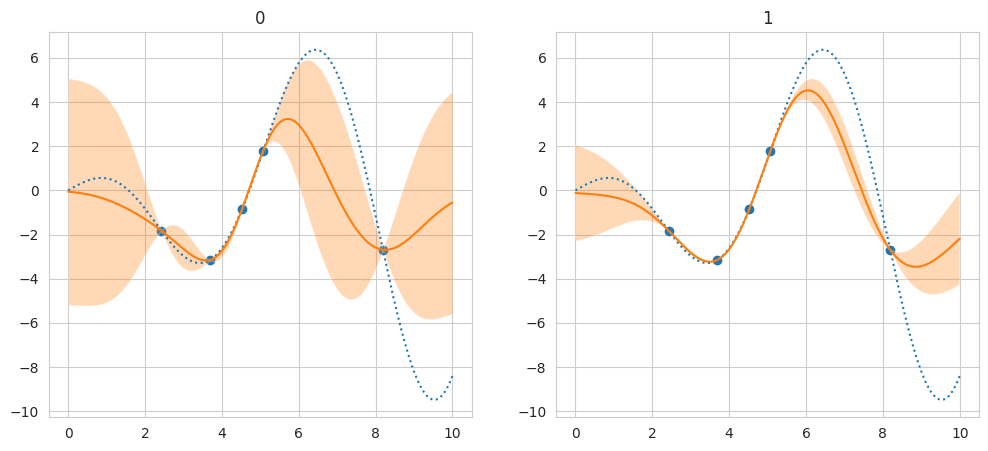

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * RBF(l)
        #gaussian_process = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=1e-10)
        gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=9)
        gaussian_process.fit(X_train, y_train)
        print(gaussian_process.kernel_)
        print(gaussian_process.log_marginal_likelihood_value_)
    else:
        kernel = RBFKernel(s, l)
        gaussian_process = GPR(X_train, y_train, covariance_function=kernel)
        gaussian_process.fit()
        print(gaussian_process.covariance_function)
        print(gaussian_process.get_log_likelihood())

    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    ax.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    ax.scatter(X_train, y_train, label="Observations")
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.3,
    )
    ax.set_title(i)
plt.show()